# _Variational Autoencoder_: PyTorch & MNIST - _Dense_ layers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.9.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Specify hyper-parameters-
num_epochs = 30
batch_size = 64
learning_rate = 0.001

### Load and pre-process MNIST dataset:

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [7]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )


C:\Users\Arjun\anaconda3\envs\pytorch-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 938 and test_loader: 157


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 938 & len(test_loader) = 157


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(937.5, 156.25)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 1, 28, 28]) & labels.shape: torch.Size([64])


In [14]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([64, 784])

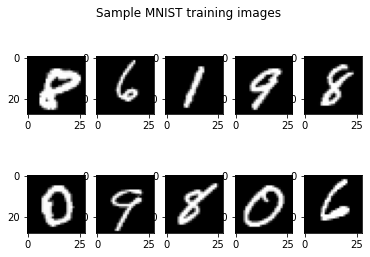

In [15]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

### _Variational Autoencoder_ architecture - _Dense_ layers

In [16]:
class VAE_Dense(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Dense, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.enc_layer1 = nn.Linear(
            in_features = 28 * 28 * 1, out_features = 512,
            bias = True
        )
        
        self.enc_layer2 = nn.Linear(
            in_features = 512, out_features = latent_space,
            bias = True
        )
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        self.hidden2log_var = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        
        # Decoder-
        self.dec_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 512,
            bias = True
        )
        self.dec_layer2 = nn.Linear(
            in_features = 512, out_features = 28 * 28 * 1,
            bias = True
        )
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = F.relu(self.enc_layer1(x.view(-1, 28 * 28 * 1)))
        x = F.relu(self.enc_layer2(x))
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        x = F.relu(self.dec_layer1(z))
        recon_data = torch.sigmoid(self.dec_layer2(x)) # or, tanh
        
        return recon_data, mu, log_var
        

In [17]:
# Initialize a VAE objetc-
model = VAE_Dense(latent_space = 5).to(device)

In [18]:
print(model)

VAE_Dense(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=5, bias=True)
  (hidden2mu): Linear(in_features=5, out_features=5, bias=True)
  (hidden2log_var): Linear(in_features=5, out_features=5, bias=True)
  (dec_layer1): Linear(in_features=5, out_features=512, bias=True)
  (dec_layer2): Linear(in_features=512, out_features=784, bias=True)
)


In [19]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([512, 784]) has 401408 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([5, 512]) has 2560 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([5, 5]) has 25 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([5, 5]) has 25 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([512, 5]) has 2560 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([784, 512]) has 401408 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [22]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 809809


### Initial _variance_ - Sanity check:

_Before_ training the VAE neural network model, there should be some initial variance.

In [20]:
for x in model.hidden2mu.parameters():
    print(x.shape, x.nelement())

torch.Size([5, 5]) 25
torch.Size([5]) 5


In [21]:
log_var_wts = model.hidden2log_var.weight

In [22]:
mu_wts = model.hidden2mu.weight

In [23]:
mu_wts = mu_wts.detach().cpu().numpy()

In [24]:
log_var_wts = log_var_wts.detach().cpu().numpy()

In [25]:
mu_wts.shape, log_var_wts.shape

((5, 5), (5, 5))

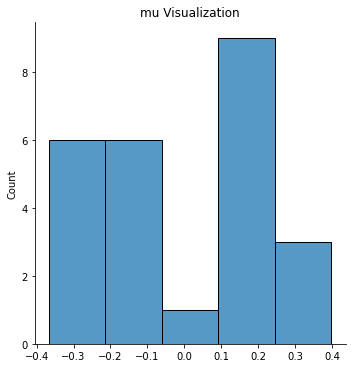

In [26]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu Visualization")
plt.show()

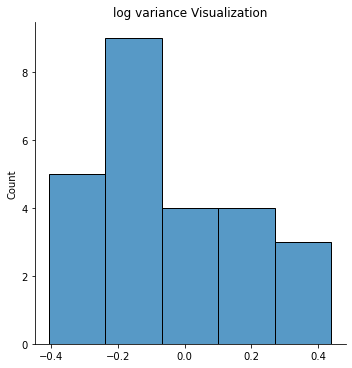

In [27]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance Visualization")
plt.show()

In [28]:
del mu_wts, log_var_wts

In [29]:
images = images.to(device)

In [30]:
images.shape

torch.Size([64, 1, 28, 28])

In [31]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [32]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 784]), torch.Size([64, 5]), torch.Size([64, 5]))

In [33]:
del recon_images, mu, log_var

In [34]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [35]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [36]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch documentations, then this is
# specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')

In [37]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [38]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        bce_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(bce_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    
    return train_loss, mu, logvar


In [39]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total = int(len(test_dataset) / dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            bce_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(bce_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()

            '''
            # save the last batch input and output of every epoch
            if i == int(len(test_dataset) / dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
            '''
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss, mu, logvar


In [ ]:
# Sanity check-
# train_loss = train_one_epoch(model = model, dataloader = train_loader, alpha = 1)

In [ ]:
# Sanity check-
# test_loss = validate_one_epoch(model = model, dataloader = test_loader, aplha = 1)

In [46]:
# print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

In [40]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [41]:
# Python dict to contain training metrics-
train_history = {}

In [42]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 30 epochs


In [43]:
for epoch in range(1, num_epochs + 1):
    train_epoch_loss, mu_train, logvar_train = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )

    val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )

    logvar_train = logvar_train.mean().detach().cpu().numpy()
    logvar_val = logvar_val.mean().detach().cpu().numpy()
    mu_train = mu_train.mean().detach().cpu().numpy()
    mu_val = mu_val.mean().detach().cpu().numpy()

    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        'val_loss': val_epoch_loss,
        'train_logvar': logvar_train,
        'val_logvar': logvar_val,
        'train_mu': mu_train,
        'val_mu': mu_val
    }

    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
    f"test loss = {val_epoch_loss:.4f}, train_logvar = {logvar_train:.6f}"
    f", train_mu = {mu_train:.6f}, val_logvar = {logvar_val:.6f} &"
    f" val_mu = {mu_val:.6f}")
    

938it [00:24, 38.53it/s]                                                                                               
157it [00:02, 70.27it/s]                                                                                               


Epoch = 1; train loss = 564.9222,test loss = 526.3487, train_logvar = -3.242538, train_mu = -0.410372, val_logvar = -3.295785 & val_mu = -0.432964


938it [00:27, 34.23it/s]                                                                                               
157it [00:02, 72.94it/s]                                                                                               


Epoch = 2; train loss = 513.9639,test loss = 509.9031, train_logvar = -4.215951, train_mu = -0.503489, val_logvar = -3.783984 & val_mu = -0.392040


938it [00:27, 34.20it/s]                                                                                               
157it [00:02, 58.96it/s]                                                                                               


Epoch = 3; train loss = 503.5053,test loss = 503.6503, train_logvar = -3.968493, train_mu = -0.424924, val_logvar = -3.703742 & val_mu = -0.361283


938it [00:27, 33.78it/s]                                                                                               
157it [00:02, 67.55it/s]                                                                                               


Epoch = 4; train loss = 498.1974,test loss = 499.0942, train_logvar = -3.729372, train_mu = -0.307252, val_logvar = -3.786148 & val_mu = -0.302332


938it [00:29, 32.14it/s]                                                                                               
157it [00:01, 80.11it/s]                                                                                               


Epoch = 5; train loss = 494.9436,test loss = 496.6619, train_logvar = -3.789744, train_mu = -0.124166, val_logvar = -3.776186 & val_mu = -0.259665


938it [00:27, 33.67it/s]                                                                                               
157it [00:02, 67.79it/s]                                                                                               


Epoch = 6; train loss = 492.7587,test loss = 495.2298, train_logvar = -3.898631, train_mu = -0.219262, val_logvar = -3.714926 & val_mu = -0.236539


938it [00:28, 33.16it/s]                                                                                               
157it [00:02, 65.42it/s]                                                                                               


Epoch = 7; train loss = 491.1763,test loss = 493.8175, train_logvar = -4.022129, train_mu = -0.236286, val_logvar = -3.894810 & val_mu = -0.233281


938it [00:28, 33.19it/s]                                                                                               
157it [00:02, 77.91it/s]                                                                                               


Epoch = 8; train loss = 489.7151,test loss = 492.7557, train_logvar = -4.005558, train_mu = -0.227018, val_logvar = -3.821938 & val_mu = -0.203325


938it [00:28, 33.18it/s]                                                                                               
157it [00:02, 71.90it/s]                                                                                               


Epoch = 9; train loss = 488.4819,test loss = 491.8487, train_logvar = -3.821387, train_mu = -0.122920, val_logvar = -3.862149 & val_mu = -0.235049


938it [00:27, 34.35it/s]                                                                                               
157it [00:02, 68.00it/s]                                                                                               


Epoch = 10; train loss = 487.5092,test loss = 490.6660, train_logvar = -3.933377, train_mu = -0.199993, val_logvar = -3.852396 & val_mu = -0.219078


938it [00:28, 33.00it/s]                                                                                               
157it [00:02, 59.33it/s]                                                                                               


Epoch = 11; train loss = 486.4280,test loss = 489.7921, train_logvar = -3.980959, train_mu = -0.247878, val_logvar = -3.881266 & val_mu = -0.196143


938it [00:28, 32.93it/s]                                                                                               
157it [00:02, 75.72it/s]                                                                                               


Epoch = 12; train loss = 485.6782,test loss = 489.3476, train_logvar = -3.833818, train_mu = -0.114563, val_logvar = -3.868406 & val_mu = -0.201678


938it [00:28, 32.39it/s]                                                                                               
157it [00:02, 69.03it/s]                                                                                               


Epoch = 13; train loss = 485.0132,test loss = 488.7201, train_logvar = -3.812292, train_mu = -0.191008, val_logvar = -3.803949 & val_mu = -0.189597


938it [00:28, 33.43it/s]                                                                                               
157it [00:02, 63.34it/s]                                                                                               


Epoch = 14; train loss = 484.1140,test loss = 489.3127, train_logvar = -3.874294, train_mu = -0.171698, val_logvar = -3.877127 & val_mu = -0.222130


938it [00:27, 33.81it/s]                                                                                               
157it [00:02, 69.86it/s]                                                                                               


Epoch = 15; train loss = 483.4925,test loss = 487.9809, train_logvar = -3.983365, train_mu = -0.240051, val_logvar = -3.899042 & val_mu = -0.198035


938it [00:29, 32.03it/s]                                                                                               
157it [00:02, 69.76it/s]                                                                                               


Epoch = 16; train loss = 482.9445,test loss = 486.9742, train_logvar = -4.117385, train_mu = -0.261348, val_logvar = -3.958131 & val_mu = -0.166199


938it [00:28, 33.05it/s]                                                                                               
157it [00:02, 76.15it/s]                                                                                               


Epoch = 17; train loss = 482.0507,test loss = 486.1317, train_logvar = -4.010552, train_mu = -0.086546, val_logvar = -3.976016 & val_mu = -0.163387


938it [00:29, 32.28it/s]                                                                                               
157it [00:02, 72.01it/s]                                                                                               


Epoch = 18; train loss = 481.5503,test loss = 486.1118, train_logvar = -4.000056, train_mu = -0.235889, val_logvar = -3.992427 & val_mu = -0.175066


938it [00:27, 34.35it/s]                                                                                               
157it [00:02, 64.39it/s]                                                                                               


Epoch = 19; train loss = 481.1153,test loss = 486.0501, train_logvar = -4.022594, train_mu = -0.221026, val_logvar = -4.007664 & val_mu = -0.173833


938it [00:29, 32.18it/s]                                                                                               
157it [00:02, 65.12it/s]                                                                                               


Epoch = 20; train loss = 480.7001,test loss = 485.7432, train_logvar = -4.010121, train_mu = -0.267220, val_logvar = -3.991590 & val_mu = -0.186847


938it [00:28, 33.09it/s]                                                                                               
157it [00:02, 72.93it/s]                                                                                               


Epoch = 21; train loss = 480.3666,test loss = 485.3136, train_logvar = -4.022922, train_mu = -0.230466, val_logvar = -4.023368 & val_mu = -0.175687


938it [00:28, 32.59it/s]                                                                                               
157it [00:02, 77.54it/s]                                                                                               


Epoch = 22; train loss = 480.0176,test loss = 485.1577, train_logvar = -4.090878, train_mu = -0.156912, val_logvar = -4.086317 & val_mu = -0.172169


938it [00:29, 32.14it/s]                                                                                               
157it [00:02, 62.79it/s]                                                                                               


Epoch = 23; train loss = 479.5880,test loss = 484.2279, train_logvar = -4.111521, train_mu = -0.254529, val_logvar = -4.054121 & val_mu = -0.126270


938it [00:28, 32.82it/s]                                                                                               
157it [00:02, 68.72it/s]                                                                                               


Epoch = 24; train loss = 479.0635,test loss = 484.1762, train_logvar = -4.084072, train_mu = -0.343693, val_logvar = -4.038136 & val_mu = -0.154288


938it [00:27, 33.59it/s]                                                                                               
157it [00:02, 64.78it/s]                                                                                               


Epoch = 25; train loss = 478.7206,test loss = 483.8740, train_logvar = -3.979512, train_mu = -0.062983, val_logvar = -4.020265 & val_mu = -0.106460


938it [00:27, 34.05it/s]                                                                                               
157it [00:02, 68.91it/s]                                                                                               


Epoch = 26; train loss = 478.3005,test loss = 483.1375, train_logvar = -4.058555, train_mu = -0.151814, val_logvar = -4.077645 & val_mu = -0.146241


938it [00:27, 33.89it/s]                                                                                               
157it [00:02, 67.02it/s]                                                                                               


Epoch = 27; train loss = 477.9221,test loss = 483.1717, train_logvar = -4.139944, train_mu = 0.019570, val_logvar = -4.062337 & val_mu = -0.134877


938it [00:27, 33.61it/s]                                                                                               
157it [00:02, 66.55it/s]                                                                                               


Epoch = 28; train loss = 477.7147,test loss = 482.7376, train_logvar = -4.108309, train_mu = -0.101886, val_logvar = -4.057516 & val_mu = -0.143531


938it [00:28, 32.37it/s]                                                                                               
157it [00:02, 75.37it/s]                                                                                               


Epoch = 29; train loss = 477.4162,test loss = 482.8217, train_logvar = -4.214827, train_mu = -0.083079, val_logvar = -4.113636 & val_mu = -0.126201


938it [00:27, 34.05it/s]                                                                                               
157it [00:02, 74.70it/s]                                                                                               

Epoch = 30; train loss = 477.1281,test loss = 482.5064, train_logvar = -4.147546, train_mu = -0.071238, val_logvar = -4.080703 & val_mu = -0.114561


In [44]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_Dense_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_Dense_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [45]:
import pickle

# Save training history as pickle file-
with open("VAE_Dense_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_Dense_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

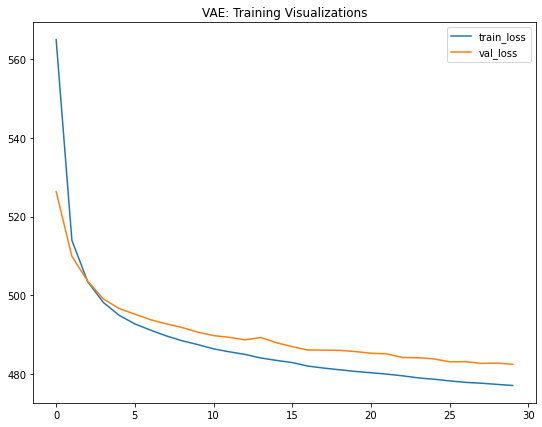

In [46]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.plot([train_history[x]['val_loss'] for x in train_history.keys()], label = 'val_loss')
plt.legend(loc = 'best')
plt.title("VAE: Training Visualizations")
plt.show()

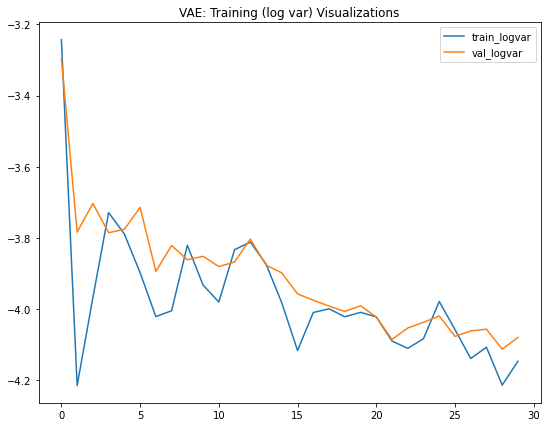

In [47]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_logvar'] for x in train_history.keys()], label = 'train_logvar')
plt.plot([train_history[x]['val_logvar'] for x in train_history.keys()], label = 'val_logvar')
plt.legend(loc = 'best')
plt.title("VAE: Training (log var) Visualizations")
plt.show()

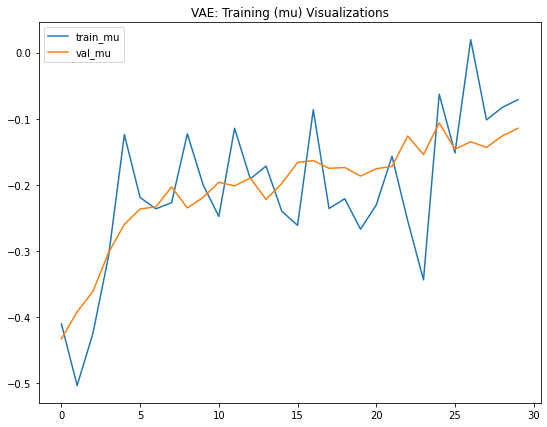

In [48]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_mu'] for x in train_history.keys()], label = 'train_mu')
plt.plot([train_history[x]['val_mu'] for x in train_history.keys()], label = 'val_mu')
plt.legend(loc = 'best')
plt.title("VAE: Training (mu) Visualizations")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model:

In [49]:
images = images.to(device)

In [50]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [51]:
# For CPU-
recon_images = recon_images.detach().numpy()
mu = mu.detach().numpy()
log_var = log_var.detach().numpy()

In [52]:
recon_images.shape, mu.shape, log_var.shape

((64, 784), (64, 5), (64, 5))

In [42]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [43]:
recon_images.shape

(64, 784)

In [53]:
# Reshape images for visualization-
recon_images = recon_images.reshape(-1, 1, 28, 28)

In [54]:
recon_images.shape

(64, 1, 28, 28)

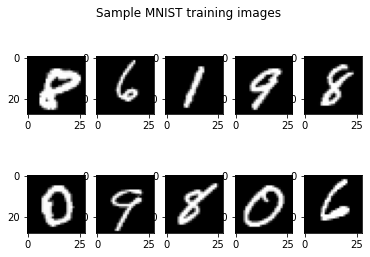

In [55]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0].cpu(), cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

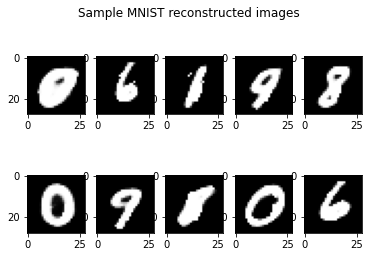

In [56]:
# Print 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

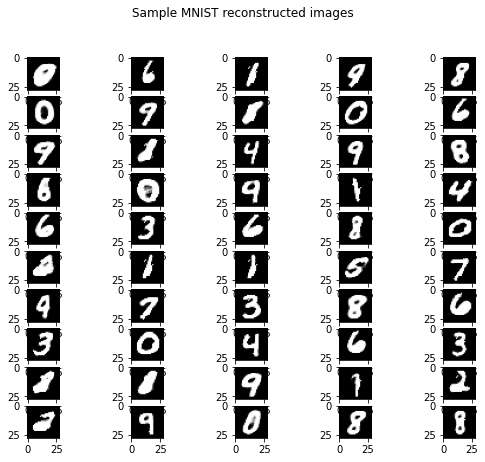

In [57]:
# Print 50 images from reconstructions-
plt.figure(figsize = (9, 7))

for i in range(50):
    plt.subplot(10, 5, i + 1)    # 10 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

In [ ]:
'''
# Iterating over train loader-
for img, label in train_loader:
    print(img.shape, label.shape)
'''

In [58]:
# Get a batch of training data & it's corresponding labels-
images, labels = next(iter(train_loader))
images = images.to(device)

In [59]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [60]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [61]:
recon_images.shape, mu.shape, log_var.shape

((64, 784), (64, 5), (64, 5))

In [ ]:
!pip install umap-learn

In [57]:
import umap
import umap.umap_ as umap

In [60]:
reducer = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [61]:
embedding_mu = reducer.fit_transform(mu)
embedding_mu.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(64, 3)

In [62]:
reducer_logvar = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [63]:
embedding_logvar = reducer.fit_transform(log_var)
embedding_logvar.shape

(64, 3)

In [64]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = embedding_mu[:, 0], y = embedding_mu[:, 1],
    z = embedding_mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = embedding_logvar[:, 0], y = embedding_logvar[:, 1],
    z = embedding_logvar[:, 2],
    # color = y_train
    )
fig.show()